In [26]:
import sys
sys.path.append('..')
from dataset import ModisDataset, Sentinel5Dataset
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from model import Model, snapshot, restore
import ignite.metrics
import pandas as pd
from train import train_epoch, test_epoch, test_model, fine_tune
from visualizations import make_and_plot_predictions, predict_future
from dataset import transform_data
from copy import deepcopy

import sklearn.metrics
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

num_layers = 3
hidden_size = 32
region = "germany"
epochs = 5
include_time = True

model_dir="/data2/igarss2020/models/"
log_dir = "/data2/igarss2020/models/"
name_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}_e={epoch}"
log_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}"

# Plotting
idx = 12
N_seen_points = 230#455
N_predictions = 100

def criterion(y_pred, y_data, log_variances):
    norm = (y_pred-y_data)**2
    loss = (torch.exp(-log_variances) * norm).mean()
    regularization = log_variances.mean()
    return 0.5 * (loss + regularization)

def setup(smooth, smooth_method="mean"):
    model = Model(input_size=1 if not include_time else 2,
                  hidden_size=hidden_size,
                  num_layers=num_layers,
                  output_size=1,
                  device=device)

    #model.load_state_dict(torch.load("/tmp/model_epoch_0.pth")["model"])
    model.train()

    enddate = '2010-01-01'

    dataset = ModisDataset(region=region,
                           fold="train",
                           znormalize=True,
                           augment=False,
                           overwrite=False,
                           include_time=include_time,
                           filter_date=(None,enddate),
                           smooth=smooth,
                           smooth_method=smooth_method)

    testdataset = ModisDataset(region=region,
                           fold="test",
                           znormalize=True,
                           augment=False,
                           overwrite=False,
                           include_time=include_time,
                           filter_date=(None,None),
                           smooth=smooth,
                           smooth_method=smooth_method)

    validdataset = ModisDataset(region=region,
                                fold="validate",
                                znormalize=True,
                                augment=False,
                                include_time=include_time,
                                smooth=smooth,
                                smooth_method=smooth_method)

    #dataset = Sentinel5Dataset(fold="train", seq_length=300)
    #validdataset = Sentinel5Dataset(fold="validate", seq_length=300)

    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=512,
                                             shuffle=True,
                                             #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                             )
    validdataloader = torch.utils.data.DataLoader(validdataset,
                                             batch_size=512,
                                             shuffle=False,
                                             #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                             )

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

    return model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer

local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
train_uptodate=2010-01-01 provided. removing all observations before 2010-01-01
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz



epoch 0: train loss 0.28, test loss 0.21, mae=0.61, mse=0.61, rmse=0.78
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=3_h=32_e=0.pth



epoch 1: train loss 0.21, test loss 0.19, mae=0.60, mse=0.59, rmse=0.77
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=3_h=32_e=1.pth



epoch 2: train loss 0.19, test loss 0.18, mae=0.60, mse=0.59, rmse=0.77
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=3_h=32_e=2.pth



epoch 3: train loss 0.18, test loss 0.18, mae=0.60, mse=0.58, rmse=0.76
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=3_h=32_e=3.pth



epoch 4: train loss 0.18, test loss 0.18, mae=0.60, mse=0.58, rmse=0.76
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=3_h=32_e=4.pth


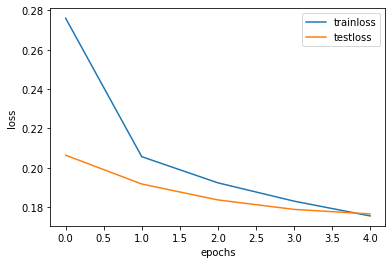

In [2]:
model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer = setup(None)
if True:
    stats=list()
    for epoch in range(epochs):
        trainloss = train_epoch(model,dataloader,optimizer, criterion, device)
        testmetrics, testloss = test_epoch(model,validdataloader,device, criterion, n_predictions=1)
        metric_msg = ", ".join([f"{name}={metric.compute():.2f}" for name, metric in testmetrics.items()])
        msg = f"epoch {epoch}: train loss {trainloss:.2f}, test loss {testloss:.2f}, {metric_msg}"
        print(msg)

        #test_model(model, validdataset, device)

        model_name = name_pattern.format(region=region, num_layers=num_layers, hidden_size=hidden_size, epoch=epoch)
        pth = os.path.join(model_dir, model_name+".pth")
        print(f"saving model snapshot to {pth}")
        snapshot(model, optimizer, pth)
        stat = dict()
        stat["epoch"] = epoch
        for name, metric in testmetrics.items():
            stat[name]=metric.compute()

        stat["trainloss"] = trainloss.cpu().detach().numpy()
        stat["testloss"] = testloss.cpu().detach().numpy()
        stats.append(stat)

    df = pd.DataFrame(stats)

    fig,ax = plt.subplots()
    ax.plot(df.epoch, df.trainloss, label="trainloss")
    ax.plot(df.epoch, df.testloss, label="testloss")
    ax.legend()
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
else:
    from dataset import download_url
    #url="https://syncandshare.lrz.de/download/MkxBRzlaTGJqS0J4RktaajN3djJB/model_weights/canada/LSTM_canada_l%3D3_h%3D32_e%3D9.pth"
    #download_url(url,"/tmp/model.pth")
    #restore("/data2/igarss2020/models/LSTM_canada_l=3_h=32_e=9.pth",model)
    restore("/data2/igarss2020/models/LSTM_germany_l=3_h=32_e=9.pth",model)
    
    

(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8646e4320>,
       dtype=object))

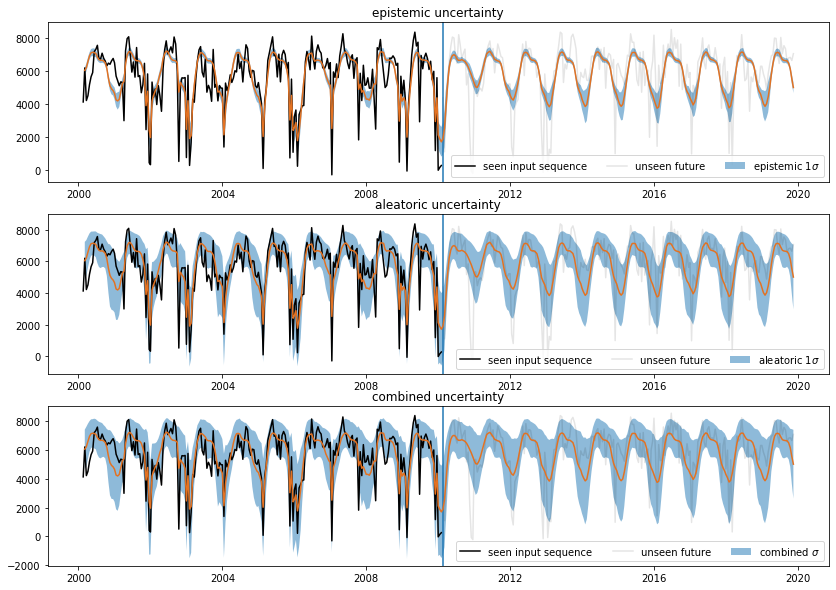

In [5]:
idx = 12
N_seen_points = 230#455
N_predictions = 100

x = testdataset.data[idx].astype(float)

finetuned_model = deepcopy(model)
optimizer = torch.optim.Adam(finetuned_model.parameters(), lr=1e-2, weight_decay=1e-6)

finetuned_model = fine_tune(x[:N_seen_points], finetuned_model, criterion, optimizer, inner_steps=0)

date = testdataset.date[idx].astype(np.datetime64)

store=None#"/home/marc/projects/igarss2020_tex/img/canada/canada"
#store=None

make_and_plot_predictions(finetuned_model, x, date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(dataset.mean,dataset.std), store=store)

In [24]:
def make_predictions(model, x, date, N_seen_points=250, N_predictions=50, ylim=None, device=torch.device('cpu'), store=None, meanstd=None):

    future = x.shape[0] - N_seen_points

    x_ = torch.Tensor(x)[None, :].to(device)
    if x_.shape[2] == 2:
        doy_seen = x_[:, :N_seen_points, 1]
        doy_future = x_[:, N_seen_points:, 1]
    else:
        doy_seen = None
        doy_future=None
    x_data = x_[:, :N_seen_points, 0].unsqueeze(2)

    mean, epi_var, ale_var,y_hat = model.predict(x_data, N_predictions, future, date=doy_seen, date_future=doy_future, return_yhat=True)
    var = epi_var + ale_var

    mean = mean.cpu().squeeze()
    var = var.cpu().squeeze()
    epi_var = epi_var.cpu().squeeze()
    ale_var = ale_var.cpu().squeeze()

    epi_std = torch.sqrt(epi_var[1:])
    ale_std = torch.sqrt(ale_var[1:])
    data_std = epi_std + ale_std

    if meanstd is not None:
        dmean, dstd = meanstd
        x = (x * dstd) + dmean
        mean = (mean * dstd) + dmean
        y_hat = (y_hat * dstd) + dmean
        ale_std = ale_std * dstd
        epi_std = epi_std * dstd
        data_std = data_std * dstd
    return mean

def calc_dtw(true,pred):
    distances = list()
    for idx in range(true.shape[0]):
        dtw, path = fastdtw(true[idx], pred[idx], dist=euclidean)
        distances.append(dtw)
    return np.array(distances).mean()

def calc_metrics(true, pred):
    mae = sklearn.metrics.mean_absolute_error(true,pred)
    mse = sklearn.metrics.mean_squared_error(true,pred)
    r2 = sklearn.metrics.r2_score(true,pred)
    return mae, mse, r2

In [ ]:
from tqdm.notebook import tqdm

def predict_finetuned(model, x, date, N_predictions, N_seen_points, lr, weight_decay, inner_steps):

    finetuned_model = deepcopy(model)
    optimizer = torch.optim.Adam(finetuned_model.parameters(), lr=lr, weight_decay=weight_decay)

    finetuned_model = fine_tune(x[:N_seen_points], finetuned_model, 
                                criterion, optimizer, inner_steps=inner_steps,device=device)

    pred = make_predictions(finetuned_model, x, date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                                  device=device,meanstd=(dataset.mean,dataset.std), store=None)

    dstd = dataset.std
    dmean = dataset.mean

    pred = pred[N_seen_points:].cpu().numpy()
    true = x[N_seen_points:,0]
    true = (true * dstd) + dmean

    true = true * 1e-4
    pred = pred * 1e-4
    return true, pred

dataset = validdataset

inner_steps = 1
lr = 1e-2
weight_decay=1e-6
N_predictions = 50

N_data = dataset.data.shape[0]
true = list()
pred = list() 
for idx in tqdm(range(N_data), total=N_data):

    N_seen_points = np.where(dataset.date[idx].astype(str) == "2010-01-01")[0][0]
    x = dataset.data[idx].astype(float)
    date = testdataset.date[idx].astype(np.datetime64)

    true_, pred_ = predict_finetuned(model, x, date, N_predictions, N_seen_points, lr, weight_decay, inner_steps)
    true.append(true_)
    pred.append(pred_)

true = np.stack(true)
pred = np.stack(pred)

In [55]:
mae, mse, r2 = calc_metrics(true.reshape(-1), pred.reshape(-1))
print(f"MAE {mae:.4f}, MSE {mse:.4f}, R2 {r2:.4f}")

MAE 0.1590, MSE 0.0453, R2 0.1598
